**сеть Кохонена (SOM), кластеризация**

Евгений Борисов esborisov@sevsu.ru

Кластеризатор на основе нейронной сети Кохонена.   
http://mechanoid.su/neural-net-kohonen-clusterization.html

Kohonen, T. (1988), Learning Vector Quantization, Neural Networks, 1 (suppl 1), 303.

https://sci2s.ugr.es/keel/pdf/algorithm/articulo/1990-Kohonen-PIEEE.pdf

In [1]:
import numpy as np
from numpy import random as rng
import matplotlib.pyplot as plt

---

In [2]:
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = 'all'

# np.set_printoptions(precision=3,suppress=True)

## данные

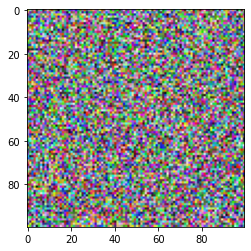

In [3]:
map_size = 100
grid_size = (map_size,map_size)
colors = rng.uniform(size=(map_size,map_size,3))

plt.imshow(colors)

In [4]:
X = colors.reshape(np.prod(grid_size),3)
X.shape

(10000, 3)

## модель

каждый нейрон первого (распределительного) слоя    
соединен со всеми нейронами второго (выходного) слоя,  
которые расположены в виде двумерной решетки.

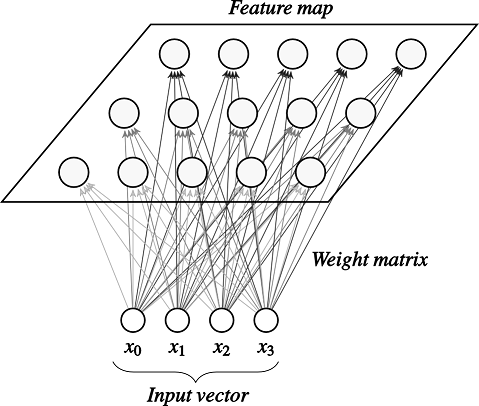

https://www.liveinternet.ru/community/rss_rss_hh_full/post418940841/

Задача векторного квантования состоит в наилучшей аппроксимации всей совокупности векторов данных ${\displaystyle k}$
кодовыми векторами ${\displaystyle W_{j}}$.

Самоорганизующиеся карты Кохонена также аппроксимируют данные, 
однако при наличии дополнительной структуры в совокупности кодовых векторов (англ. codebook).

Каждая точка данных отображается соответствующим кодовым вектором из решётки. 

Так получают представление данных на плоскости («карту данных»). 

При отображении этих слоёв полезен аппарат географических информационных систем (ГИС).   
В ГИС подложкой для изображения информационных слоев служит географическая карта.

$$\|x,w\|+b $$

https://masters.donntu.org/2018/fknt/shumskyi/library/article8.pdf

In [5]:
# from sklearn.metrics.pairwise import euclidean_distances

# def state(x,w,b): # состояние нейронов
#     return euclidean_distances(x,w)+b

# def score(x,weight): 
#     w,b = weight
#     s = state(x,w,b)
#     return np.argmin(s, axis=1), s

# def predict(x,weight): 
#     w,b = weight
#     return np.argmin( state(x,w,b), axis=1)

In [6]:
def state(x,w,b): # состояние нейронов
    return x.dot(w.T)+b

def score(x,weight): 
    w,b = weight
    s = state(x,w,b)
    return np.argmax(s, axis=1), s

def predict(x,weight): 
    w,b = weight
    return np.argmax( state(x,w,b), axis=1)

In [7]:
# инициализация параметров сети
def weight_init(input_size,output_size):
    out_count = np.prod(grid_size) # количество нейронов выходного слоя
    return [
        rng.normal(size=(out_count,input_size),scale=.1), # веса
        np.zeros(out_count), # сдвиги
    ]

In [8]:
# map_size = 9
# grid_size = (map_size,map_size)

# weight = weight_init(input_size=X.shape[1],output_size=grid_size)
# # predict(X,weight)

## обучение

In [9]:
def gauss(d,s=.1): # функция окрестности
    return np.exp(-np.square(d)/s)

Text(0.5, 1.0, 'функция окрестности')

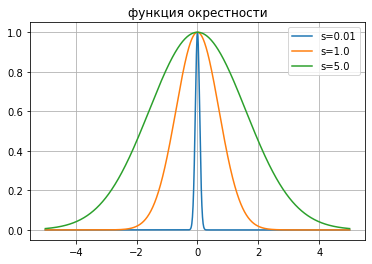

In [10]:
d = np.linspace(-5,5,1000)
plt.plot(d,gauss(d,s=.01),label='s=0.01')
plt.plot(d,gauss(d,s=1.),label='s=1.0')
plt.plot(d,gauss(d,s=5.),label='s=5.0')
plt.grid()
plt.legend()
plt.title('функция окрестности')

In [11]:
# место (i,j) нейрона n в двумерной решетке
def number2indices(n,grid_size):
    return np.vstack([ np.unravel_index(i,grid_size) for i in n ])

# расстояние между нейронами n1 и n2 в двумерной решетке
def distance_on_map(n1,n2,grid_size):
    i1 = number2indices(n=n1,grid_size=grid_size)
    i2 = number2indices(n=n2,grid_size=grid_size)
    return np.abs( i1[:,np.newaxis,:] - i2[np.newaxis, :, :] ).max(axis=-1)

# векторы расстояний от ка ждого нейрона до всех остальных нейронов двумерной решетки
def distance_on_map_all(grid_size):
    n = list(range(np.prod(grid_size)))
    return distance_on_map(n,n,grid_size)

In [12]:
# grid_distance = distance_on_map_all(grid_size)
# grid_distance

In [13]:
# коэффициенты окрестности для нейронов номер [n1,n2,...]
def neighbor_score(n,sig,grid_distance):
    return gauss( grid_distance[n,:], s=sig )

# neighbor_score([1,2,3],sig=.5)

---

изменение весов

$$
\Delta w = \eta\cdot \theta(k) \cdot (x − w)
$$


$\eta \in (0,1)$ - шаг обучения   

$k$ - номер нейрона-победителя

$\theta(k)_{j} \in [0,1]$ - значение ф-ции окрестности нейрона-победителя $k$ для нейрона $j$;


При обучении сети Кохонена возникает проблема так называемых "мертвых" нейронов.   
Одно из ограничений всякого конкурирующего слоя состоит в том, что некоторые нейроны оказываются незадействованными.

для борьбы с "мертвыми" нейронами используется изменение смещения нейронов

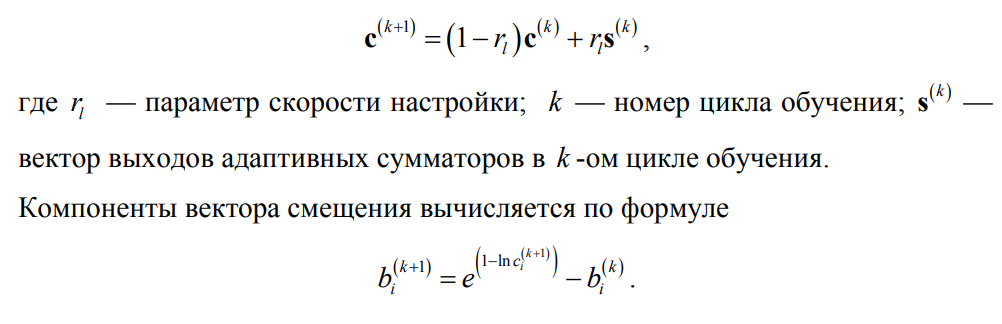

---

In [14]:
def get_batch(x,batch_size):
    n_samples = len(x) # количество учебных пар
    batch_count = np.ceil( n_samples/batch_size).astype(int) # количество батчей
    # перемешиваем учебный набор и режем его на батчи
    for idx in np.array_split(rng.permutation(n_samples), batch_count ):
        yield x[idx,:]

In [15]:
def fit_batch(x,weight,lr,sig,activity,grid_distance):
    # определяем выходной нейрон-победитель
    winner,s = score(x,weight) 

    # значение функции окрестности нейрона-победителя для всех выходных нейронов
    nb = neighbor_score(winner,sig=sig,grid_distance=grid_distance)  

    w,b = weight

    # изменение весов
    dw = ((x[:,np.newaxis,:]-w[np.newaxis,:,:])*nb[:,:,np.newaxis]).mean(axis=0)

    # корректируем параметр активности нейронов
    a = ( ((1.-lr)*activity)[np.newaxis,:] + (lr*s)).mean(axis=0)
    
    # считаем изменение сдвигов
    with np.errstate(divide='ignore',invalid='ignore',):
        db = np.where( a>0., np.exp(1.-np.log(a)), 0. )
        #dbm = np.abs(db).max()
        #if dbm>0.: db/=np.abs(db).max()    
        
    return [ w+lr*dw, b-db ], a

In [16]:
def fit_epoch(x,weight,lr,sig,activity,grid_distance,batch_size): # эпоха обучения
    weight_ = weight.copy()
    activity_ = activity.copy()
    for xb in get_batch(x,batch_size): # для всех точек учебного датасета
        weight_, activity_ = fit_batch( xb, weight_, lr, sig, activity_,grid_distance) # подстраиваем веса
    return weight_, activity_

In [17]:
def msqe(a,b): # среднее квадратичное отклонение
    return np.square(a-b).mean()

In [18]:
def input_variance(x,weight): # среднее отклонение входа от вектора весов победителя
    win = predict(x,weight)
    return np.mean([ msqe(weight[0][c], x[win==c]) for c in set(win) ])

In [19]:
X_train = X

In [20]:
from tqdm import tqdm

В начале процедуры настройки всем нейронам конкурирующего слоя присваивается одинаковый параметр активности

In [21]:
# grid_size = (101,101) # размеры решетки выходного слоя
weight = weight_init(input_size=X_train.shape[1],output_size=grid_size)

In [22]:
n_epoch = 500 # количество циклов обучения

lr = .5 # скорость обучения
lr_step = .99 # шаг уменьшения скорости обучения
lr_min = .05 # минимальная скорость обучения

# параметр размера окрестности для нейрона-победителя
sig = np.sqrt(len(weight[1])).astype(int) 
sig_step = .85 # шаг уменьшения размера окрестности
sig_min = .01 # минимальное значение параметра размера окрестности

dw_history = [] # история отклонения весов
inp_var_history = [] # история изменения среднего отклонения входа от вектора весов победителя
lr_history = [] # история изменения скорости обучения
sig_history = [] # история изменения размера окрестности для нейрона-победителя

weight_var_threshold = 1e-9 # минимально существенное отклонение весов
inp_var_threshold = 1e-2

batch_size = len(X_train)//3 # размер одного пакета учебных данных

# параметр активности для каждого выходного нейрона
activity = np.ones(len(weight[1]))/len(weight[1])

# векторы расстояний от каждого нейрона до всех остальных нейронов двумерной решетки
grid_distance = distance_on_map_all(grid_size)

In [23]:
%%time 

epoch = tqdm(range(n_epoch))
for i in epoch:
    w = weight[0].copy() # сохраняем старые значения весов
    
    # шаг обучения модели
    weight, activity = fit_epoch(X_train,weight,lr,sig,activity,grid_distance,batch_size) 
       
    dw_history.append(msqe(weight[0],w)) # считаем отклонение весов
    
    inp_var_history.append( input_variance(X_train,weight) )
    
    epoch.set_postfix({'weight diff':dw_history[-1],'lr':lr,'sig':sig,'var':inp_var_history[-1]})
    lr= max(lr*lr_step,lr_min) # уменьшаем скорость обучения
    sig = max(sig*sig_step,sig_min) # уменьшаем размер окрестности нейрона-победителя

    lr_history.append(lr) # история изменения скорости обучения
    sig_history.append(sig) # история изменения размера окрестности для нейрона-победителя
    
    if dw_history[-1]<weight_var_threshold: # если нет существенного изменения весов...
        print('low weight variance detected')
        break # ... то выходим
        
    if inp_var_history[-1]<inp_var_threshold:
        print('low variance detected')
        break

100%|██████████| 500/500 [34:18<00:00,  4.12s/it, weight diff=3.86e-7, lr=0.05, sig=0.01, var=0.28]   

CPU times: user 33min 43s, sys: 14min 17s, total: 48min 1s
Wall time: 34min 18s


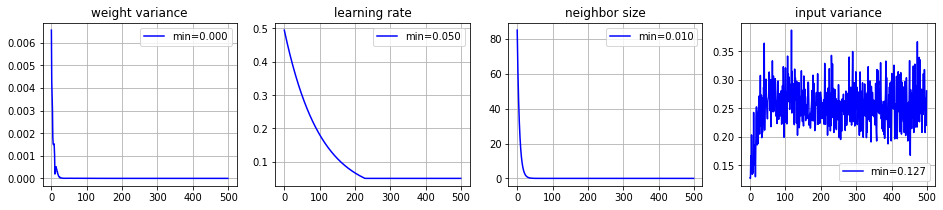

In [24]:
history = {
'weight variance':dw_history,
'learning rate':lr_history,
'neighbor size':sig_history,
'input variance': inp_var_history,
}

fig,ax = plt.subplots(1,len(history),figsize=(16,3))
for i,t in enumerate(history):
    ax[i].plot(history[t],c='b',label='min=%.3f'%min(history[t]))
    ax[i].grid()
    ax[i].legend()
    ax[i].set_title(t)

## тестируем

In [25]:
p = predict(X_train,weight)

In [26]:
set(p)

{1543, 2926, 6594, 8691, 8893}

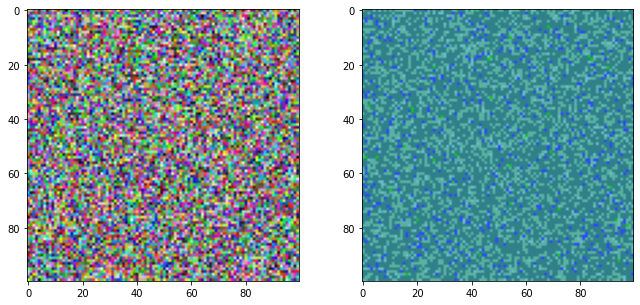

In [27]:
fig,ax = plt.subplots(1,2,figsize=(11,5))

ax[0].imshow( X_train.reshape(list(grid_size)+[3]) )
ax[1].imshow( X_train[p.reshape(grid_size)] )